In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/data/

Mounted at /content/drive
[Errno 2] No such file or directory: '/content/drive/MyDrive/data/'
/content


In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf

# sk 하이닉스

In [53]:
df_sk = pd.read_csv('/content/drive/MyDrive/학술/sk_감성지수.csv', index_col = 0)
df_sk_h = pd.read_csv('/content/drive/MyDrive/학술/sk하이닉스_감성지수.csv', index_col = 0)
df_sk_h_s = pd.read_csv('/content/drive/MyDrive/sk하이닉스주가.csv', encoding = 'CP949')

In [54]:
df_sk_h =pd.merge(df_sk, df_sk_h, on = 'time')

In [55]:
sk_h_s = df_sk_h_s[['날짜','종가', '등락률']]
sk_h_s.columns = ['time','final', 'updown']

In [56]:
sk_h_s.loc[sk_h_s['updown'] > 0, 'updown'] = 1
sk_h_s.loc[sk_h_s['updown'] <= 0, 'updown'] = 0

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [57]:
scaler = MinMaxScaler()
sk_h_s_cols = ['final']
sk_h_s_scaled = scaler.fit_transform(sk_h_s[sk_h_s_cols])
sk_h_s_scaled = pd.DataFrame(sk_h_s_scaled)
sk_h_s_scaled.columns = sk_h_s_cols

sk_h_s_scaled

,final
0,0.315723
1,0.323270
2,0.320755
3,0.320755
4,0.320755
...,...
725,0.742138
726,0.716981
727,0.735849
728,0.729560


In [58]:
sk_h_s = sk_h_s.drop(['final'], axis = 1)

In [59]:
sk_h_s = pd.concat([sk_h_s, sk_h_s_scaled], axis=1)

In [60]:
df_sk_h = df_sk_h.drop(['time'], axis = 1)

In [61]:
sk_h = pd.concat([sk_h_s,df_sk_h], axis =1)

In [62]:
sk_h

,time,updown,final,0_x,0_y
0,2020-01-01,0.0,0.315723,0.001147,0.002468
1,2020-01-02,1.0,0.323270,0.002169,0.003185
2,2020-01-03,0.0,0.320755,0.001200,0.001847
3,2020-01-04,0.0,0.320755,0.000084,-0.000146
4,2020-01-05,0.0,0.320755,0.000455,0.000408
...,...,...,...,...,...
725,2021-12-26,1.0,0.742138,0.000089,-0.000443
726,2021-12-27,0.0,0.716981,0.000860,0.000543
727,2021-12-28,1.0,0.735849,0.000715,0.000942
728,2021-12-29,0.0,0.729560,0.000460,0.000805


In [63]:
sk_h.columns = ['time','updown','final','mom_s','son_s']

In [64]:
sk_h = sk_h.set_index('time')

In [65]:
test_size = 730-670
window_size = 10
train = sk_h[:-test_size]
test = sk_h[-test_size:]

## 설명변수 : 종가

In [223]:
  def make_dataset(data, label, window_size=5):
      feature_list = []
      label_list = []
      for i in range(len(data) - window_size):
          feature_list.append(np.array(data.iloc[i:i+window_size]))
          label_list.append(np.array(label.iloc[i+window_size]))
      return np.array(feature_list), np.array(label_list)

In [224]:
X_train = train.drop(['updown','mom_s','son_s'], axis =1)
y_train = train.drop(['final','mom_s','son_s'], axis =1)

X_test = test.drop(['updown','mom_s','son_s'], axis =1)
y_test = test.drop(['final','mom_s','son_s'], axis = 1)

In [228]:
X_train, y_train = make_dataset(X_train, y_train, 5)

X_test, y_test = make_dataset(X_test, y_test, 5)
X_test.shape, y_test.shape

AttributeError: ignored

In [229]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

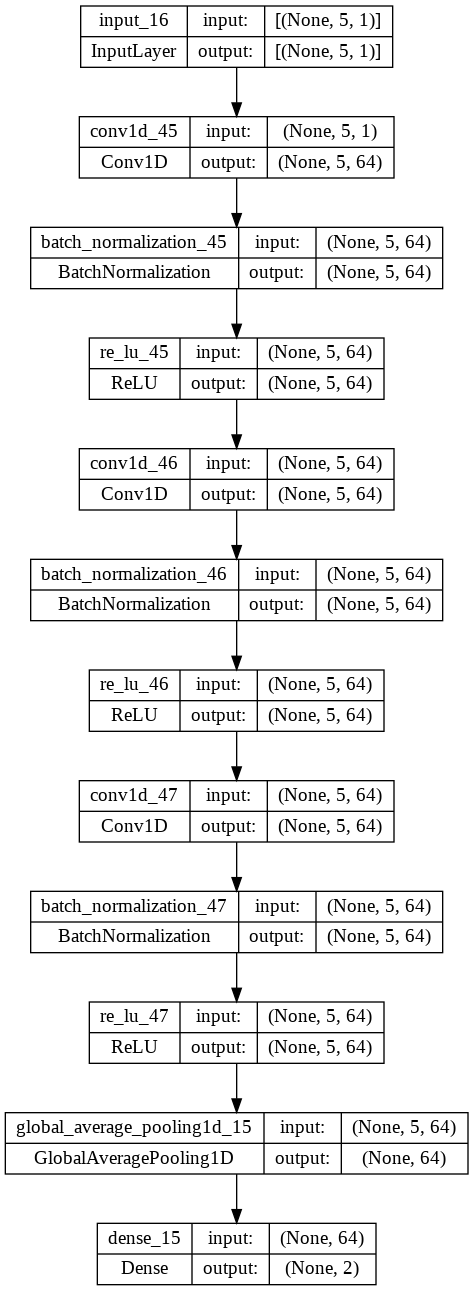

In [230]:
model = make_model(input_shape = X_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [231]:
epochs = 500
batch_size = 32
tf.random.set_seed(1004)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
17/17 [==============================] - 2s 30ms/step - loss: 0.7223 - sparse_categorical_accuracy: 0.5000 - val_loss: 0.7046 - val_sparse_categorical_accuracy: 0.4135 - lr: 0.0010
Epoch 2/500
17/17 [==============================] - 0s 13ms/step - loss: 0.6875 - sparse_categorical_accuracy: 0.5508 - val_loss: 0.7027 - val_sparse_categorical_accuracy: 0.4135 - lr: 0.0010
Epoch 3/500
17/17 [==============================] - 0s 12ms/step - loss: 0.6899 - sparse_categorical_accuracy: 0.5244 - val_loss: 0.6942 - val_sparse_categorical_accuracy: 0.4211 - lr: 0.0010
Epoch 4/500
17/17 [==============================] - 0s 12ms/step - loss: 0.6725 - sparse_categorical_accuracy: 0.5789 - val_loss: 0.6877 - val_sparse_categorical_accuracy: 0.5865 - lr: 0.0010
Epoch 5/500
17/17 [==============================] - 0s 11ms/step - loss: 0.6924 - sparse_categorical_accuracy: 0.5583 - val_loss: 0.6865 - val_sparse_categorical_accuracy: 0.5865 - lr: 0.0010
Epoch 6/500
17/17 [================

In [232]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

2/2 [==============================] - 0s 8ms/step - loss: 0.7005 - sparse_categorical_accuracy: 0.4909
Test accuracy 0.4909090995788574
Test loss 0.7005319595336914


## 설명변수 : 종가, 모회사 감성지수

In [83]:
X_train = train.drop(['updown','son_s'], axis =1)
y_train = train.drop(['final','mom_s','son_s'], axis =1)

X_test = test.drop(['updown','son_s'], axis =1)
y_test = test.drop(['final','mom_s','son_s'], axis = 1)

In [84]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [85]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [86]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [87]:
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))

In [88]:
num_classes = len(np.unique(y_train))

In [90]:
idx = np.random.permutation(len(X_train))
X_train = X_train[idx]
y_train = y_train[idx]

In [91]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [92]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

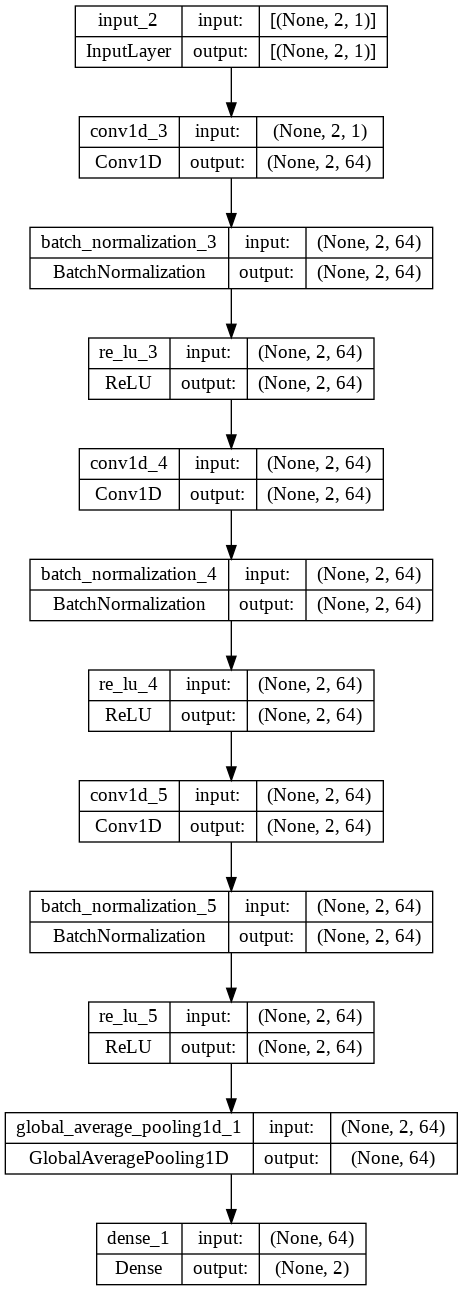

In [93]:
model = make_model(input_shape = X_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [94]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
17/17 [==============================] - 2s 30ms/step - loss: 0.7116 - sparse_categorical_accuracy: 0.5522 - val_loss: 0.6926 - val_sparse_categorical_accuracy: 0.5149 - lr: 0.0010
Epoch 2/500
17/17 [==============================] - 0s 8ms/step - loss: 0.7032 - sparse_categorical_accuracy: 0.5317 - val_loss: 0.6930 - val_sparse_categorical_accuracy: 0.5149 - lr: 0.0010
Epoch 3/500
17/17 [==============================] - 0s 8ms/step - loss: 0.6910 - sparse_categorical_accuracy: 0.5205 - val_loss: 0.6938 - val_sparse_categorical_accuracy: 0.5149 - lr: 0.0010
Epoch 4/500
17/17 [==============================] - 0s 8ms/step - loss: 0.6939 - sparse_categorical_accuracy: 0.5410 - val_loss: 0.6967 - val_sparse_categorical_accuracy: 0.5149 - lr: 0.0010
Epoch 5/500
17/17 [==============================] - 0s 9ms/step - loss: 0.6968 - sparse_categorical_accuracy: 0.5280 - val_loss: 0.6980 - val_sparse_categorical_accuracy: 0.5149 - lr: 0.0010
Epoch 6/500
17/17 [====================

In [95]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

2/2 [==============================] - 0s 10ms/step - loss: 0.6938 - sparse_categorical_accuracy: 0.4833
Test accuracy 0.4833333194255829
Test loss 0.6937990784645081


## 설명변수 : 종가, 자회사 지수

In [151]:
X_train = train.drop(['updown','mom_s'], axis =1)
y_train = train.drop(['final','mom_s','son_s'], axis =1)

X_test = test.drop(['updown','mom_s'], axis =1)
y_test = test.drop(['final','mom_s','son_s'], axis = 1)

In [152]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [153]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [154]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [155]:
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))

In [156]:
num_classes = len(np.unique(y_train))

In [104]:
idx = np.random.permutation(len(X_train))
X_train = X_train[idx]
y_train = y_train[idx]

In [105]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [106]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [107]:
num_classes = len(np.unique(y_train))

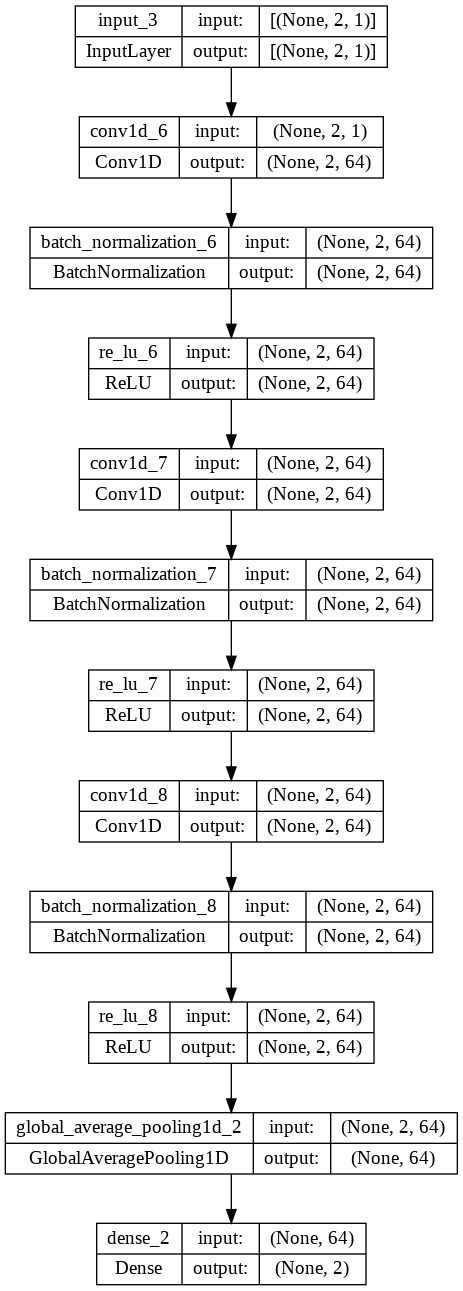

In [108]:
model = make_model(input_shape = X_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [109]:
tf.random.set_seed(1004)
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
17/17 [==============================] - 2s 26ms/step - loss: 0.7148 - sparse_categorical_accuracy: 0.5504 - val_loss: 0.6959 - val_sparse_categorical_accuracy: 0.4701 - lr: 0.0010
Epoch 2/500
17/17 [==============================] - 0s 8ms/step - loss: 0.6955 - sparse_categorical_accuracy: 0.5093 - val_loss: 0.6966 - val_sparse_categorical_accuracy: 0.4701 - lr: 0.0010
Epoch 3/500
17/17 [==============================] - 0s 8ms/step - loss: 0.6960 - sparse_categorical_accuracy: 0.5280 - val_loss: 0.6963 - val_sparse_categorical_accuracy: 0.4701 - lr: 0.0010
Epoch 4/500
17/17 [==============================] - 0s 8ms/step - loss: 0.6863 - sparse_categorical_accuracy: 0.5336 - val_loss: 0.6965 - val_sparse_categorical_accuracy: 0.4701 - lr: 0.0010
Epoch 5/500
17/17 [==============================] - 0s 10ms/step - loss: 0.6860 - sparse_categorical_accuracy: 0.5560 - val_loss: 0.6953 - val_sparse_categorical_accuracy: 0.4701 - lr: 0.0010
Epoch 6/500
17/17 [===================

In [110]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

2/2 [==============================] - 0s 10ms/step - loss: 0.6932 - sparse_categorical_accuracy: 0.5167
Test accuracy 0.5166666507720947
Test loss 0.6931722164154053


## 설명변수 : 종가, 모회사 감성지수, 자회사 감성지수

In [233]:
X_train = train.drop(['updown'], axis =1)
y_train = train.drop(['final','mom_s','son_s'], axis =1)

X_test = test.drop(['updown'], axis =1)
y_test = test.drop(['final','mom_s','son_s'], axis = 1)

In [234]:
X_train, y_train = make_dataset(X_train, y_train, 5)

X_test, y_test = make_dataset(X_test, y_test, 5)
X_test.shape, y_test.shape

((55, 5, 3), (55, 1))

In [235]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

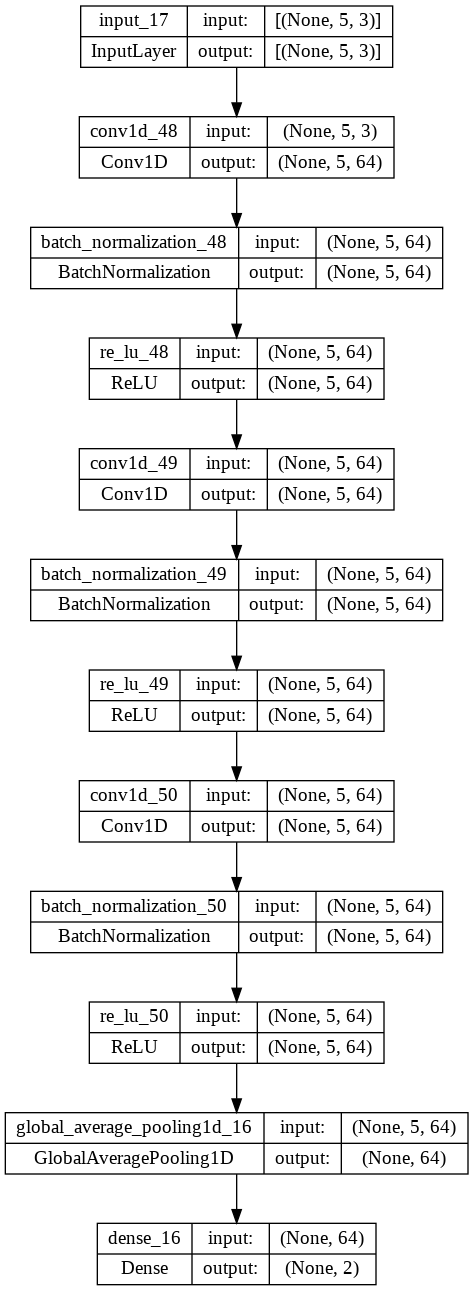

In [236]:
model = make_model(input_shape = X_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [237]:
epochs = 500
batch_size = 32
tf.random.set_seed(1004)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
17/17 [==============================] - 28s 27ms/step - loss: 0.7201 - sparse_categorical_accuracy: 0.5056 - val_loss: 0.7072 - val_sparse_categorical_accuracy: 0.4135 - lr: 0.0010
Epoch 2/500
17/17 [==============================] - 0s 8ms/step - loss: 0.6954 - sparse_categorical_accuracy: 0.5263 - val_loss: 0.7143 - val_sparse_categorical_accuracy: 0.4135 - lr: 0.0010
Epoch 3/500
17/17 [==============================] - 0s 9ms/step - loss: 0.6849 - sparse_categorical_accuracy: 0.5508 - val_loss: 0.7087 - val_sparse_categorical_accuracy: 0.4135 - lr: 0.0010
Epoch 4/500
17/17 [==============================] - 0s 9ms/step - loss: 0.6699 - sparse_categorical_accuracy: 0.5827 - val_loss: 0.7084 - val_sparse_categorical_accuracy: 0.4135 - lr: 0.0010
Epoch 5/500
17/17 [==============================] - 0s 11ms/step - loss: 0.6915 - sparse_categorical_accuracy: 0.5414 - val_loss: 0.7050 - val_sparse_categorical_accuracy: 0.4586 - lr: 0.0010
Epoch 6/500
17/17 [==================

In [238]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

2/2 [==============================] - 0s 9ms/step - loss: 0.7064 - sparse_categorical_accuracy: 0.4909
Test accuracy 0.4909090995788574
Test loss 0.7064409255981445
